In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# setting directory
DIR_ = "D:/Drive/OneDrive/Documents/MIMIC"
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"

In [3]:
#Reading CSV using pandas
notes_df = pd.read_csv(DIR + "NOTEEVENTS.csv", low_memory=False)
admissions_df = pd.read_csv(DIR + "ADMISSIONS.csv", low_memory=False)

# Admissions

In [4]:
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,4/9/2196 12:26,4/10/2196 15:54,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,4/9/2196 10:06,4/9/2196 13:24,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,9/3/2153 7:15,9/8/2153 19:10,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,10/18/2157 19:34,10/25/2157 14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,6/6/2139 16:14,6/9/2139 12:48,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,11/2/2160 2:06,11/5/2160 14:55,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,11/2/2160 1:01,11/2/2160 4:27,ACUTE CORONARY SYNDROME,0,1


In [5]:
admissions_df.shape

(58976, 19)

Types of admissions

In [6]:
admissions_df['ADMISSION_TYPE'].unique()

array(['EMERGENCY', 'ELECTIVE', 'NEWBORN', 'URGENT'], dtype=object)

Check for missing values on the admission times

In [7]:
sum(admissions_df['ADMITTIME'].isnull())


0

Conversion of times to datetime type

In [8]:
# Conversion of times to datetime type
admissions_df['ADMITTIME'] = admissions_df['ADMITTIME'].astype('datetime64[ns]')
admissions_df['DISCHTIME'] = admissions_df['DISCHTIME'].astype('datetime64[ns]')
admissions_df['DEATHTIME'] = admissions_df['DEATHTIME'].astype('datetime64[ns]')

Sort by subject and admission type and reset the data frame index.

In [9]:
# Sort by subject and admission type and reset the data frame index.
admissions_df = admissions_df.sort_values(['SUBJECT_ID', 'ADMITTIME'])
admissions_df = admissions_df.reset_index(drop = True)

In [10]:
# Create new columns for next admission time and type
admissions_df['NEXT_ADMITTIME'] = admissions_df.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
admissions_df['NEXT_ADMISSION_TYPE'] = admissions_df.groupby('SUBJECT_ID')['ADMISSION_TYPE'].shift(-1)


In [11]:
# admissions_df['NEXT_ADMITTIME'] = admissions_df.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# admissions_df['NEXT_ADMISSION_TYPE'] = admissions_df.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [12]:
# admissions_df[admissions_df['NEXT_ADMISSION_TYPE'] == 'ELECTIVE']['NEXT_ADMITTIME'] = pd.NaT
# admissions_df[admissions_df['NEXT_ADMISSION_TYPE'] == 'ELECTIVE']['NEXT_ADMISSION_TYPE'] = np.NaN

In [13]:
# Update the DataFrame using .loc to avoid SettingWithCopyWarning
admissions_df.loc[admissions_df['NEXT_ADMISSION_TYPE'] == 'ELECTIVE', 'NEXT_ADMITTIME'] = pd.NaT
admissions_df.loc[admissions_df['NEXT_ADMISSION_TYPE'] == 'ELECTIVE', 'NEXT_ADMISSION_TYPE'] = np.NaN

print(admissions_df)

       ROW_ID  SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0           1           2   163353 2138-07-17 19:04:00 2138-07-21 15:48:00   
1           2           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
2           3           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
3           4           5   178980 2103-02-02 04:31:00 2103-02-04 12:15:00   
4           5           6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   
...       ...         ...      ...                 ...                 ...   
58971   58972       99985   176670 2181-01-27 02:47:00 2181-02-12 17:05:00   
58972   58973       99991   151118 2184-12-24 08:30:00 2185-01-05 12:15:00   
58973   58974       99992   197084 2144-07-25 18:03:00 2144-07-28 17:56:00   
58974   58975       99995   137810 2147-02-08 08:00:00 2147-02-11 13:15:00   
58975   58976       99999   113369 2117-12-30 07:15:00 2118-01-04 16:30:00   

      DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0 

Fill NA's with the next valid value. Previously sorted.

In [14]:
admissions_df[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admissions_df.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

Obtain days to readmission: from discharge to next readmission

In [15]:
admissions_df['DAYS_TO_READMISSION'] = (admissions_df['NEXT_ADMITTIME'] - admissions_df['DISCHTIME']).dt.days

Number of readmissions

In [16]:
sum(admissions_df['DAYS_TO_READMISSION'].notnull())

11399

Distribution of days to readmission

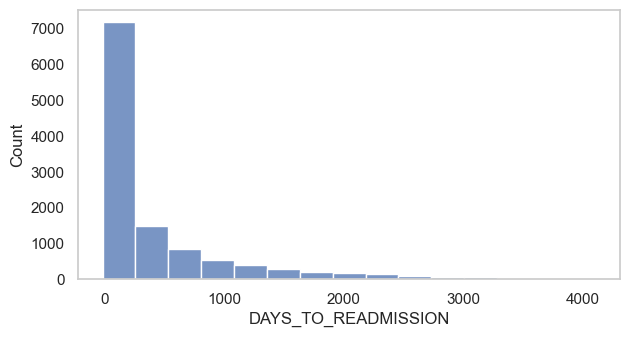

In [17]:
import seaborn as sns

# Set figure size and grid
sns.set(rc={'figure.figsize': (7, 3.5), 'axes.grid': True})

# Set style
sns.set_style("whitegrid", {'axes.grid': False})

# Create histogram plot
fig = sns.histplot(admissions_df['DAYS_TO_READMISSION'], kde=False, bins=15)

# Get the figure object from the plot
fig = fig.get_figure()

# Save the figure as a file
fig.savefig('days_dist.png')


In [18]:
# printing mean 
print(admissions_df['DAYS_TO_READMISSION'].quantile(0.5))
print(admissions_df['DAYS_TO_READMISSION'].quantile(0.75))
print(admissions_df['DAYS_TO_READMISSION'].quantile(0.25))
print(admissions_df['DAYS_TO_READMISSION'].mean())
admissions_df['DAYS_TO_READMISSION'].max()

120.0
507.0
23.0
408.8103342398456


4107.0

# Notes

In [19]:
notes_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [20]:
notes_df.shape

(2083180, 11)

In [21]:
notes_df['CATEGORY'].unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [22]:
discharge_notes = notes_df[notes_df['CATEGORY'] == "Discharge summary"]
discharge_notes.shape

(59652, 11)

There are 6926 admissions with more than one discharge note (HADM_ID - ID of Admissions).

In [23]:
discharge_notes.duplicated(['HADM_ID']).sum()

6926

Take the last row per admission

In [24]:
discharge_notes_ordered = discharge_notes.groupby(['SUBJECT_ID', 'HADM_ID']).nth(-1).reset_index()

In [25]:
discharge_notes_ordered.duplicated(['HADM_ID']).sum()

0

In [26]:
discharge_notes_ordered.shape

(52726, 11)

# Merge Notes and Admissions

In [27]:
# Merges `admissions_df` with `discharge_notes_ordered` on `SUBJECT_ID` and `HADM_ID`.
admissions_notes = pd.merge(
    admissions_df[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_TO_READMISSION','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
    discharge_notes_ordered[['SUBJECT_ID', 'HADM_ID', 'TEXT']], 
    on = ['SUBJECT_ID', 'HADM_ID'], how='left'
)

In [28]:
admissions_notes

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_TO_READMISSION,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,TEXT
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NaT,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2101-10-20**] Discharg...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2191-3-16**] Discharge...
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NaT,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2175-5-30**] Dischar...
...,...,...,...,...,...,...,...,...,...
58971,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2181-1-27**] ...
58972,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2184-12-24**] ...
58973,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2144-7-25**] ...
58974,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2147-2-8**] D...


10% of admissions without discharge notes.

In [29]:
sum(admissions_notes['TEXT'].isnull()) / len(admissions_notes)

0.1059753119913185

53% of NEWBORN are missing

In [30]:
admissions_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/admissions_notes.groupby('ADMISSION_TYPE').size()


ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

Remove NEWBORN admissions and create the target variable

In [31]:
# Filter out 'NEWBORN' admission types
adm_notes = admissions_notes[admissions_notes['ADMISSION_TYPE'] != 'NEWBORN'].copy()

# Create the 'READM_WITHIN_30' column
adm_notes.loc[:, 'READM_WITHIN_30'] = (adm_notes['DAYS_TO_READMISSION'] < 30).astype('int')


In [32]:
sum(adm_notes['READM_WITHIN_30'])

3004

In [33]:
adm_notes.shape

(51113, 10)

Exlude patients that died during the admission

In [34]:
rows_not_death = adm_notes['DEATHTIME'].isnull()
df_adm_notes_not_death = adm_notes.loc[rows_not_death].copy()
df_adm_notes_not_death = df_adm_notes_not_death.sample(n = len(df_adm_notes_not_death))
df_adm_notes_not_death = df_adm_notes_not_death.reset_index(drop = True)

In [35]:
sum(df_adm_notes_not_death['READM_WITHIN_30'])

2963

In [36]:
len(df_adm_notes_not_death['READM_WITHIN_30'])

45321